In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [8]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [9]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


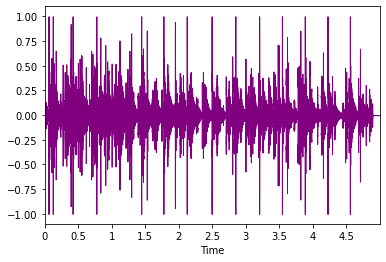

In [10]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [11]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [13]:
result = generate_features(y)

In [14]:
result.shape

(128, 480, 3)

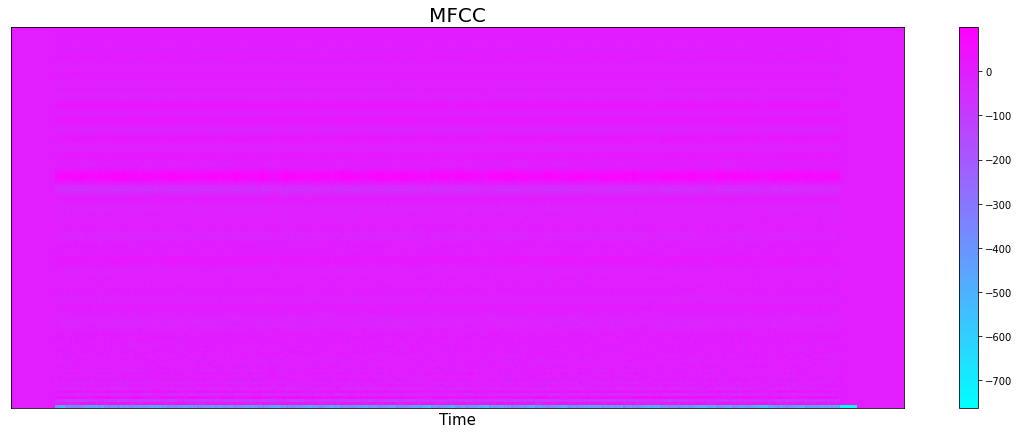

In [15]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

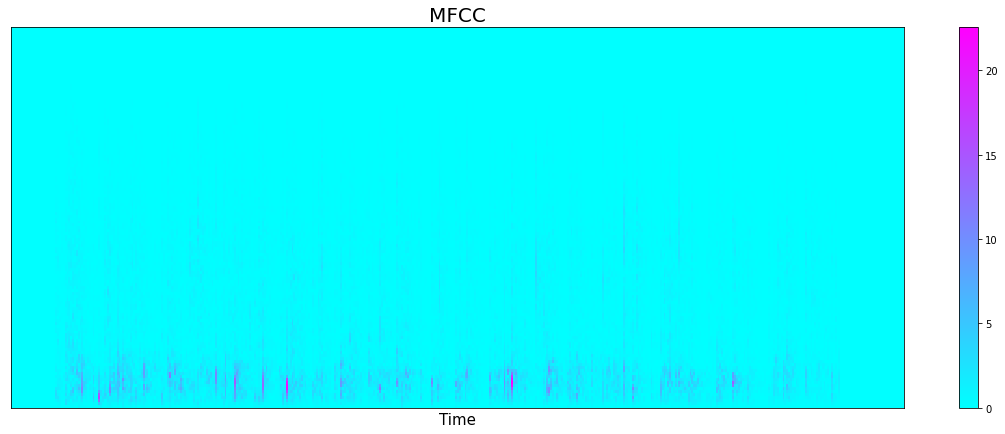

In [16]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

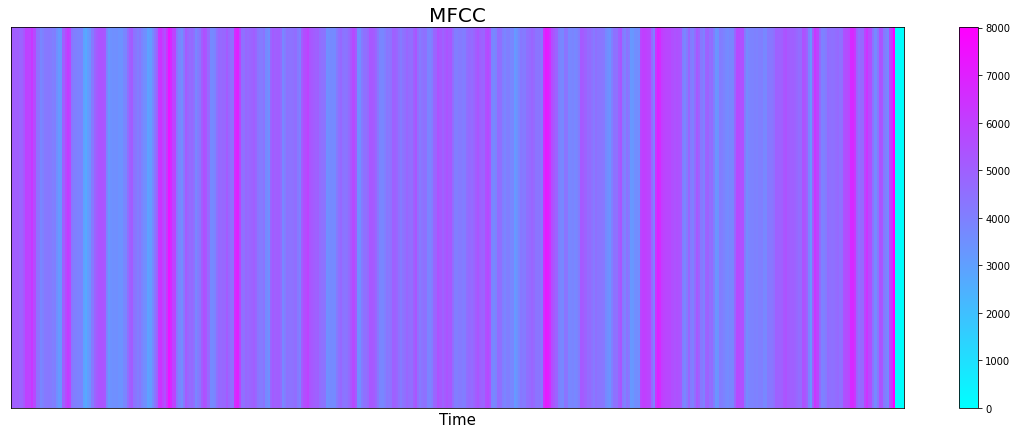

In [17]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

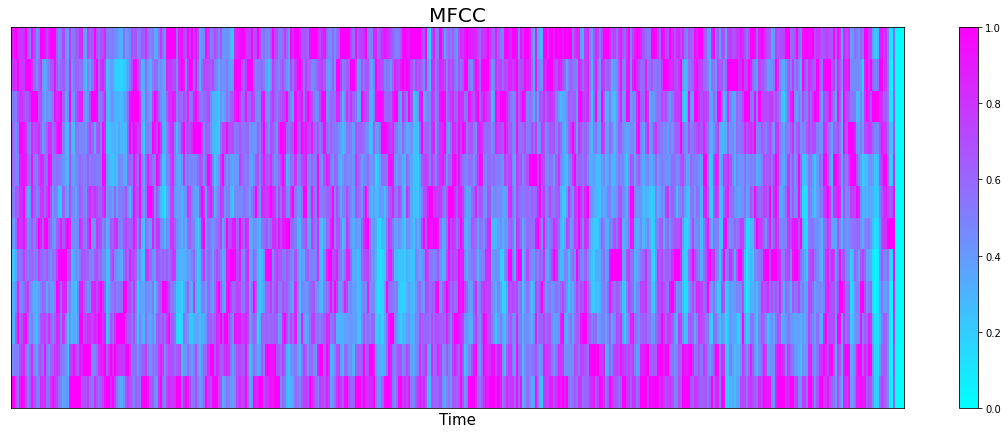

In [18]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

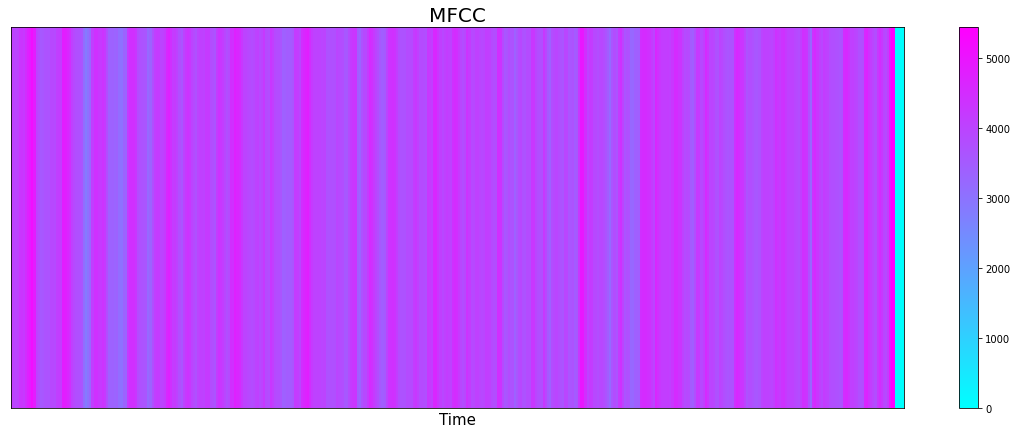

In [19]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [20]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [21]:
X, y = get_features(df, rs=(224,224))

In [22]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


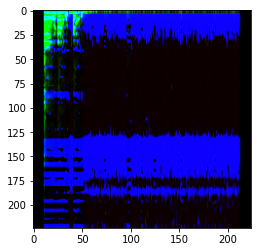

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# MODEL

In [27]:
#from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Intento 1

In [28]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-adam-Xception-0.1.h5")

83689472/83683744 [==============================] - 7s 0us/step


In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 12s 267ms/step - loss: 45.7662 - accuracy: 0.1057 - val_loss: 151737299716764327034748928.0000 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 4s 174ms/step - loss: 5.4834 - accuracy: 0.1016 - val_loss: 1662082799441543168.0000 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 4s 175ms/step - loss: 2.8545 - accuracy: 0.0922 - val_loss: 107467035901952.0000 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 4s 173ms/step - loss: 2.5683 - accuracy: 0.1419 - val_loss: 385157824512.0000 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 4s 174ms/step - loss: 2.5052 - accuracy: 0.1230 - val_loss: 28277116928.0000 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 4s 174ms/step - loss: 2.4979 - accuracy: 0.0954 - val_loss: 2881652480.0000 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 4s 175

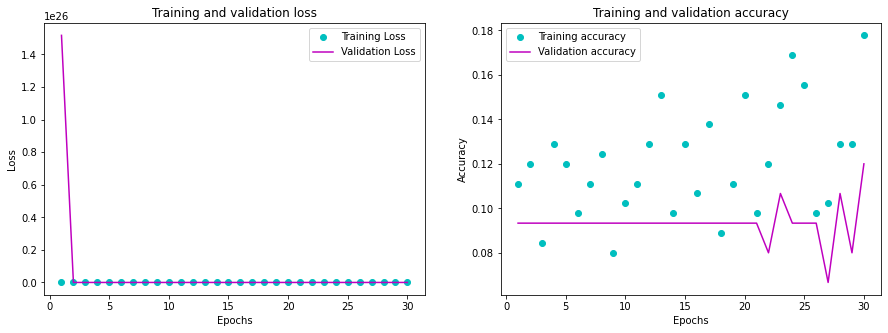

In [31]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [32]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 1s 222ms/step - loss: 2.3844 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]], shape=(10, 10), dtype=int32)


In [33]:
model.save("model/Xception/fit-adam-Xception-0.1.h5")

# Intento 2 

In [34]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-adam-Xception-0.01.h5")

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 203ms/step - loss: 4.3307 - accuracy: 0.1004 - val_loss: 153327058944.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 176ms/step - loss: 2.3975 - accuracy: 0.1743 - val_loss: 58271996.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 178ms/step - loss: 2.1356 - accuracy: 0.1742 - val_loss: 1773137.3750 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 175ms/step - loss: 2.0147 - accuracy: 0.2239 - val_loss: 450007.9062 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 4s 177ms/step - loss: 2.0985 - accuracy: 0.1913 - val_loss: 107606.1484 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 178ms/step - loss: 2.0495 - accuracy: 0.1558 - val_loss: 320.7307 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 176ms/step - loss: 1.9544 - accuracy: 0.2467 - val_loss: 

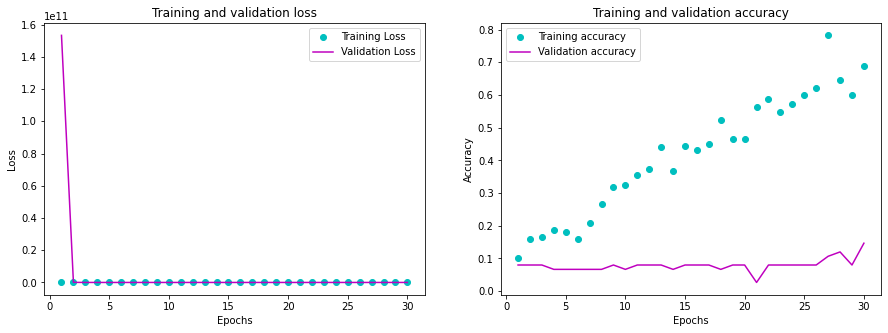

In [37]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [38]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 108.3104 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]], shape=(10, 10), dtype=int32)


In [39]:
model.save("model/Xception/fit-adam-Xception-0.01.h5")

# Intento 3 

In [40]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-adam-Xception-0.001.h5")

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 214ms/step - loss: 2.2762 - accuracy: 0.1754 - val_loss: 116.1876 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 4s 176ms/step - loss: 1.8252 - accuracy: 0.4346 - val_loss: 2123.7515 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 4s 177ms/step - loss: 1.5300 - accuracy: 0.5325 - val_loss: 1789.5508 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 4s 181ms/step - loss: 1.2204 - accuracy: 0.6178 - val_loss: 1541.8043 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 4s 177ms/step - loss: 0.9549 - accuracy: 0.7079 - val_loss: 481.3844 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 4s 178ms/step - loss: 0.9149 - accuracy: 0.7380 - val_loss: 178.5333 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 4s 191ms/step - loss: 0.7912 - accuracy: 0.7800 - val_loss: 62.9591 - val_accurac

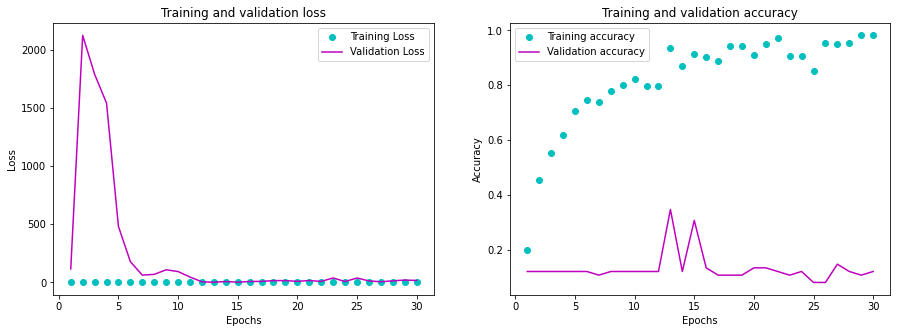

In [43]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [44]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 73ms/step - loss: 13.9396 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]], shape=(10, 10), dtype=int32)


In [45]:
model.save("model/Xception/fit-adam-Xception-0.001.h5")

# intento 4

In [46]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-adam-Xception-0.0001.h5")

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [48]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 204ms/step - loss: 2.1821 - accuracy: 0.2257 - val_loss: 22.8559 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 177ms/step - loss: 1.2462 - accuracy: 0.6322 - val_loss: 18.6140 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 176ms/step - loss: 0.6142 - accuracy: 0.8562 - val_loss: 18.6276 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 177ms/step - loss: 0.2632 - accuracy: 0.9622 - val_loss: 19.5104 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 177ms/step - loss: 0.1498 - accuracy: 0.9768 - val_loss: 10.4548 - val_accuracy: 0.0400
Epoch 6/30
23/23 [==============================] - 4s 178ms/step - loss: 0.1677 - accuracy: 0.9698 - val_loss: 6.4898 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 177ms/step - loss: 0.0955 - accuracy: 0.9820 - val_loss: 3.3947 - val_accuracy: 0.1333
E

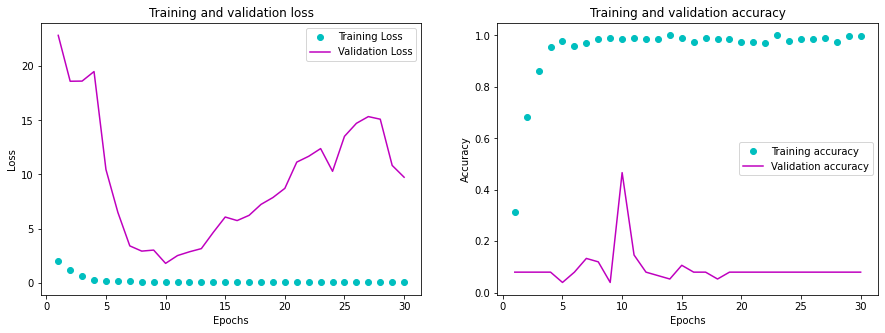

In [49]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [50]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 70ms/step - loss: 10.9009 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]], shape=(10, 10), dtype=int32)


In [51]:
model.save("model/Xception/fit-adam-Xception-0.0001.h5")

# intento 5

In [52]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-adam-Xception-0.00001.h5")

In [53]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [54]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 201ms/step - loss: 2.2431 - accuracy: 0.1327 - val_loss: 12.4890 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 4s 179ms/step - loss: 2.0527 - accuracy: 0.2764 - val_loss: 7.6352 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 4s 179ms/step - loss: 1.8179 - accuracy: 0.5521 - val_loss: 10.2520 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 178ms/step - loss: 1.6753 - accuracy: 0.5933 - val_loss: 14.5311 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 175ms/step - loss: 1.5668 - accuracy: 0.6252 - val_loss: 11.0608 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 4s 177ms/step - loss: 1.3768 - accuracy: 0.6906 - val_loss: 9.3087 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 4s 180ms/step - loss: 1.1608 - accuracy: 0.8176 - val_loss: 3.1091 - val_accuracy: 0.0533
Ep

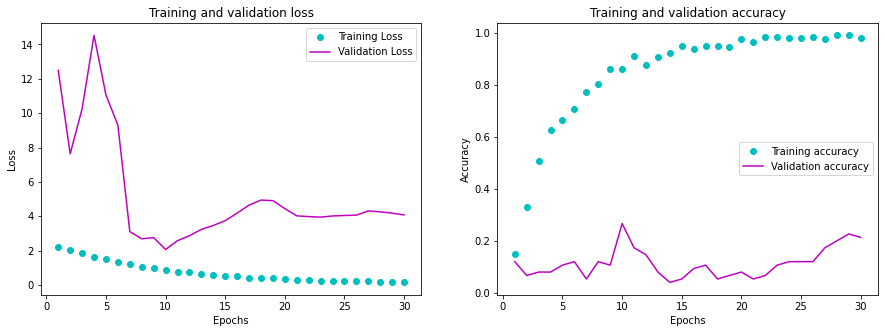

In [55]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [56]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 75ms/step - loss: 3.8592 - accuracy: 0.0800
Confusion_matrix:  tf.Tensor(
[[0 0 0 5 0 0 0 4 0 1]
 [0 0 0 3 0 0 0 5 0 2]
 [0 0 0 2 0 0 0 1 0 7]
 [0 0 0 6 0 0 0 3 0 1]
 [0 0 0 2 0 0 0 4 0 4]
 [0 0 0 7 0 0 0 3 0 0]
 [0 0 0 4 0 0 0 6 0 0]
 [0 0 0 6 0 0 0 2 0 2]
 [0 0 0 8 0 0 0 2 0 0]
 [0 0 0 9 0 0 0 1 0 0]], shape=(10, 10), dtype=int32)


In [57]:
model.save("model/Xception/fit-adam-Xception-0.00001.h5")

# cambio de SGD

# INTENTO 1

In [58]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-SGD-Xception-0.1.h5")

In [59]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 207ms/step - loss: 2.2821 - accuracy: 0.2753 - val_loss: 14.4299 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 4s 174ms/step - loss: 1.4592 - accuracy: 0.4916 - val_loss: 10.4331 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 174ms/step - loss: 1.0272 - accuracy: 0.7164 - val_loss: 6.1935 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 174ms/step - loss: 0.7950 - accuracy: 0.7672 - val_loss: 18.4867 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 4s 181ms/step - loss: 0.5702 - accuracy: 0.8445 - val_loss: 9.0795 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 179ms/step - loss: 0.4443 - accuracy: 0.8566 - val_loss: 18.0740 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 176ms/step - loss: 0.5084 - accuracy: 0.8488 - val_loss: 3.5969 - val_accuracy: 0.0800
Ep

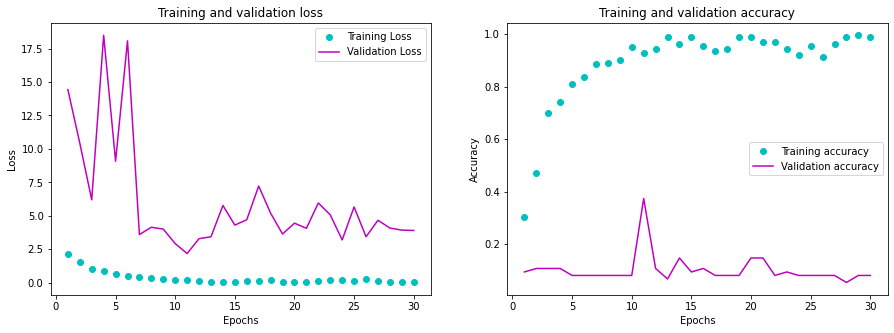

In [61]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [62]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 3.6728 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [63]:
model.save("model/Xception/fit-SGD-Xception-0.1.h5")

# INTENTO 2

In [65]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-SGD-Xception-0.01.h5")

In [66]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [67]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 201ms/step - loss: 2.3249 - accuracy: 0.1022 - val_loss: 14.7758 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 4s 172ms/step - loss: 2.0278 - accuracy: 0.3660 - val_loss: 31.2536 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 172ms/step - loss: 1.5628 - accuracy: 0.6069 - val_loss: 35.1510 - val_accuracy: 0.0667
Epoch 4/30
23/23 [==============================] - 4s 174ms/step - loss: 1.2349 - accuracy: 0.7358 - val_loss: 37.9005 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 4s 179ms/step - loss: 1.0012 - accuracy: 0.7539 - val_loss: 18.8150 - val_accuracy: 0.0533
Epoch 6/30
23/23 [==============================] - 4s 176ms/step - loss: 0.6579 - accuracy: 0.9180 - val_loss: 25.9357 - val_accuracy: 0.0400
Epoch 7/30
23/23 [==============================] - 4s 176ms/step - loss: 0.6396 - accuracy: 0.8581 - val_loss: 26.7553 - val_accuracy: 0.0533

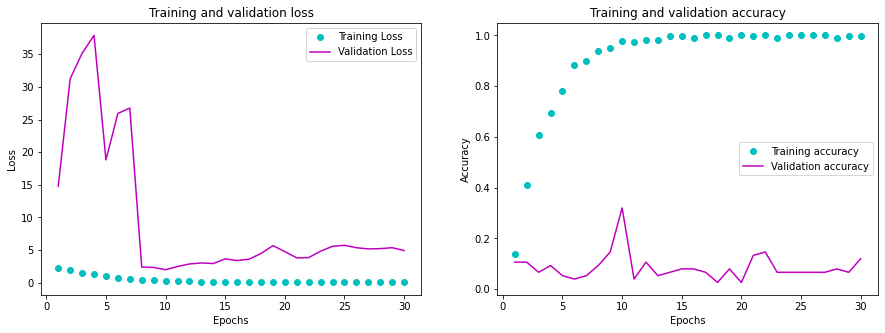

In [68]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [69]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 4.0983 - accuracy: 0.1800
Confusion_matrix:  tf.Tensor(
[[0 0 2 0 0 0 0 3 0 5]
 [0 0 0 0 0 0 0 2 0 8]
 [1 0 7 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 8 0 2]
 [0 0 6 0 0 0 0 1 0 3]
 [0 0 0 0 0 0 0 8 0 2]
 [0 0 3 0 0 0 0 4 0 3]
 [0 0 0 0 0 0 0 5 0 5]
 [0 0 0 0 0 0 0 7 0 3]
 [0 0 1 0 0 0 0 3 0 6]], shape=(10, 10), dtype=int32)


In [70]:
model.save("model/Xception/fit-SGD-Xception-0.01.h5")

# INTENTO 3

In [71]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-SGD-Xception-0.001.h5")

In [72]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [73]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 201ms/step - loss: 2.3727 - accuracy: 0.0889 - val_loss: 17.1743 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3069 - accuracy: 0.0862 - val_loss: 19.3032 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 174ms/step - loss: 2.2818 - accuracy: 0.1181 - val_loss: 15.6652 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 174ms/step - loss: 2.2225 - accuracy: 0.2559 - val_loss: 10.6143 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 4s 174ms/step - loss: 2.1655 - accuracy: 0.2243 - val_loss: 12.9043 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 176ms/step - loss: 2.1856 - accuracy: 0.2530 - val_loss: 6.5578 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 174ms/step - loss: 2.1306 - accuracy: 0.3388 - val_loss: 2.7085 - val_accuracy: 0.0933
E

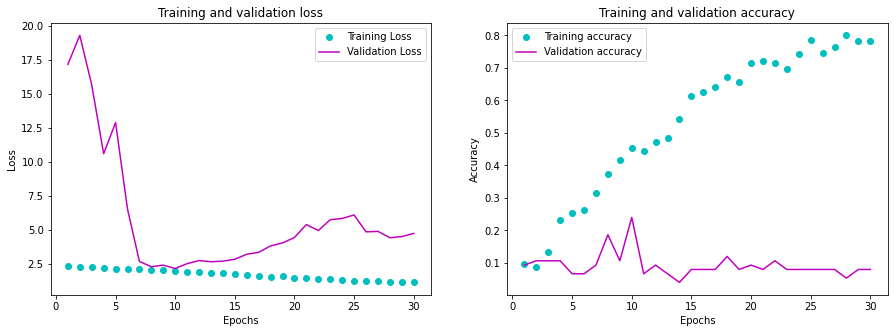

In [74]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [75]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 3.9167 - accuracy: 0.1200
Confusion_matrix:  tf.Tensor(
[[ 1  0  0  0  0  0  0  0  0  9]
 [ 0  1  0  0  0  0  0  0  0  9]
 [ 1  0  0  0  0  0  0  0  0  9]
 [ 1  0  0  0  0  0  0  0  0  9]
 [ 1  0  0  0  0  0  0  0  0  9]
 [ 1  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 1  1  0  0  0  0  0  0  0  8]
 [ 1  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0 10]], shape=(10, 10), dtype=int32)


In [76]:
model.save("model/Xception/fit-SGD-Xception-0.001.h5")

# INTENTO 4

In [77]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-SGD-Xception-0.0001.h5")

In [78]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [79]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 208ms/step - loss: 2.3139 - accuracy: 0.1203 - val_loss: 10.7685 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 4s 186ms/step - loss: 2.3073 - accuracy: 0.1379 - val_loss: 18.0392 - val_accuracy: 0.1467
Epoch 3/30
23/23 [==============================] - 4s 184ms/step - loss: 2.3284 - accuracy: 0.0870 - val_loss: 14.7244 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 4s 185ms/step - loss: 2.3344 - accuracy: 0.1298 - val_loss: 16.4711 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 4s 179ms/step - loss: 2.3324 - accuracy: 0.1019 - val_loss: 12.8695 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 185ms/step - loss: 2.3535 - accuracy: 0.0954 - val_loss: 19.5300 - val_accuracy: 0.1467
Epoch 7/30
23/23 [==============================] - 4s 176ms/step - loss: 2.3098 - accuracy: 0.1225 - val_loss: 7.8860 - val_accuracy: 0.1467


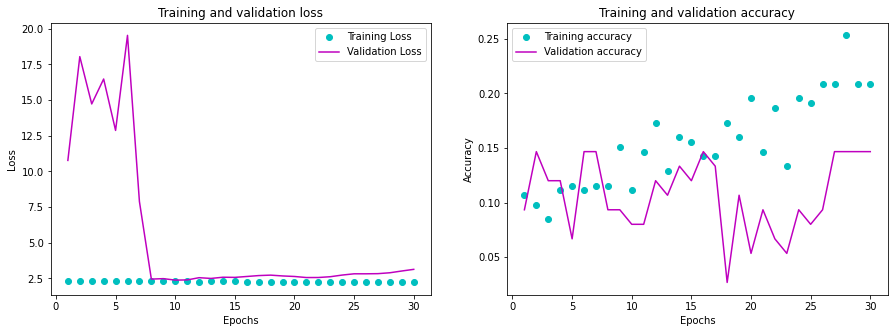

In [80]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [81]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 70ms/step - loss: 3.1513 - accuracy: 0.0800
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  3  0  0  0  7  0  0]
 [ 0  0  0  4  0  0  0  6  0  0]
 [ 0  0  0  1  0  0  2  7  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  3  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]
 [ 0  0  0  2  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]], shape=(10, 10), dtype=int32)


In [82]:
model.save("model/Xception/fit-SGD-Xception-0.0001.h5")

# INTENTO 5

In [83]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-SGD-Xception-0.00001.h5")

In [84]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [85]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 202ms/step - loss: 2.3347 - accuracy: 0.0932 - val_loss: 17.3071 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 176ms/step - loss: 2.3530 - accuracy: 0.0547 - val_loss: 24.2994 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3616 - accuracy: 0.0579 - val_loss: 18.4448 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3440 - accuracy: 0.1000 - val_loss: 21.4108 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 176ms/step - loss: 2.3684 - accuracy: 0.0743 - val_loss: 14.8031 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3811 - accuracy: 0.0439 - val_loss: 28.2326 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3352 - accuracy: 0.1030 - val_loss: 6.3144 - val_accuracy: 0.1733


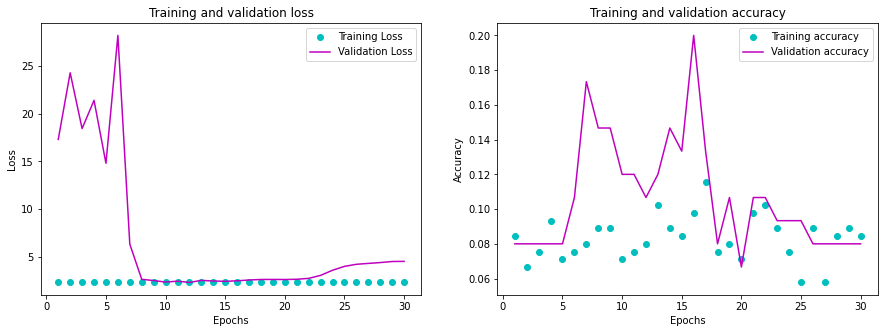

In [86]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [87]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 3.9624 - accuracy: 0.1300
Confusion_matrix:  tf.Tensor(
[[ 0  8  0  0  0  0  0  2  0  0]
 [ 0  9  0  0  0  0  0  1  0  0]
 [ 0  7  0  0  0  0  0  3  0  0]
 [ 0  2  3  0  0  0  0  5  0  0]
 [ 0  9  0  0  0  0  0  1  0  0]
 [ 0  5  0  0  0  0  0  5  0  0]
 [ 0  8  0  0  0  0  0  2  0  0]
 [ 0  6  0  0  0  0  0  4  0  0]
 [ 0  3  1  0  0  0  0  6  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [88]:
model.save("model/Xception/fit-SGD-Xception-0.00001.h5")

# Cambio a Adamax

# intento 1

In [89]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-Adamax-Xception-0.1.h5")

In [90]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [91]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 206ms/step - loss: 36.9899 - accuracy: 0.0576 - val_loss: 4773010586579333283840.0000 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 4s 180ms/step - loss: 3.6813 - accuracy: 0.0595 - val_loss: 272654170849280.0000 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 4s 182ms/step - loss: 2.6796 - accuracy: 0.1203 - val_loss: 30337810432.0000 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 184ms/step - loss: 2.3730 - accuracy: 0.1346 - val_loss: 286081184.0000 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 177ms/step - loss: 2.4750 - accuracy: 0.0698 - val_loss: 14575524.0000 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 4s 183ms/step - loss: 2.2614 - accuracy: 0.1016 - val_loss: 750098.0000 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 182ms/step - loss: 2.1248 -

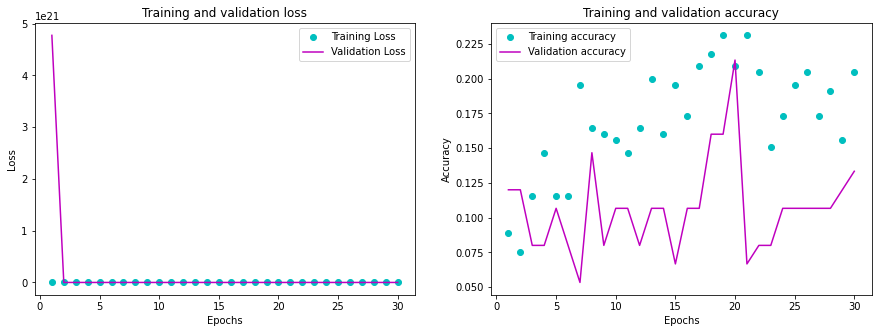

In [92]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [93]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 73ms/step - loss: 2.4725 - accuracy: 0.1300
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  5  5  0  0  0]
 [ 0  0  0  0  0  2  8  0  0  0]
 [ 0  0  0  0  0  1  9  0  0  0]
 [ 0  0  0  0  0  1  8  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  5  5  0  0  0]
 [ 0  0  0  0  0  2  8  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  1  9  0  0  0]
 [ 0  0  0  0  0  4  6  0  0  0]], shape=(10, 10), dtype=int32)


In [94]:
model.save("model/Xception/fit-Adamax-Xception-0.1.h5")

# intento 2

In [95]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-Adamax-Xception-0.01.h5")

In [96]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [97]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 206ms/step - loss: 2.9537 - accuracy: 0.1099 - val_loss: 86444.6094 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 177ms/step - loss: 2.2278 - accuracy: 0.1572 - val_loss: 5215.0493 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 178ms/step - loss: 2.2287 - accuracy: 0.1448 - val_loss: 253.1772 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 178ms/step - loss: 2.0728 - accuracy: 0.2568 - val_loss: 452.7781 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 178ms/step - loss: 2.0994 - accuracy: 0.1779 - val_loss: 217.1983 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 179ms/step - loss: 2.0829 - accuracy: 0.1960 - val_loss: 234.1146 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 177ms/step - loss: 2.0550 - accuracy: 0.2718 - val_loss: 158.4259 - val_accura

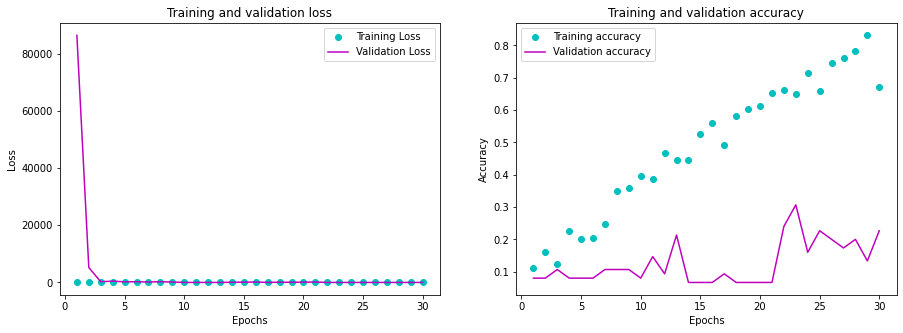

In [98]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [99]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 3.5761 - accuracy: 0.2600
Confusion_matrix:  tf.Tensor(
[[0 0 0 0 0 3 0 2 0 5]
 [1 0 0 0 0 0 0 0 0 9]
 [4 0 0 1 0 0 0 5 0 0]
 [1 0 0 4 0 3 0 0 1 1]
 [1 0 0 0 3 0 0 0 0 6]
 [0 0 0 0 0 7 0 0 0 3]
 [0 0 0 0 0 7 0 0 0 3]
 [0 0 0 2 0 4 0 3 0 1]
 [0 0 0 7 0 2 0 0 1 0]
 [0 0 0 0 0 2 0 0 0 8]], shape=(10, 10), dtype=int32)


In [100]:
model.save("model/Xception/fit-Adamax-Xception-0.01.h5")

# intento 3

In [101]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-Adamax-Xception-0.001.h5")

In [102]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [103]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 218ms/step - loss: 2.2789 - accuracy: 0.2105 - val_loss: 30.4757 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 187ms/step - loss: 1.8578 - accuracy: 0.4533 - val_loss: 43.9333 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 184ms/step - loss: 1.3381 - accuracy: 0.5708 - val_loss: 65.5859 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 193ms/step - loss: 0.7779 - accuracy: 0.7830 - val_loss: 37.7438 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 183ms/step - loss: 0.6068 - accuracy: 0.7878 - val_loss: 36.0889 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 188ms/step - loss: 0.3755 - accuracy: 0.8898 - val_loss: 65.8516 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 193ms/step - loss: 0.3222 - accuracy: 0.9146 - val_loss: 41.9462 - val_accuracy: 0.0800

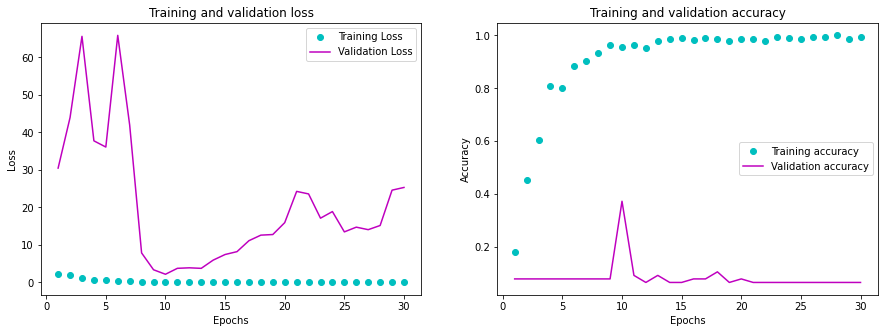

In [104]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [105]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 20.0202 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [106]:
model.save("model/Xception/fit-Adamax-Xception-0.001.h5")

# intento 4

In [107]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-Adamax-Xception-0.0001.h5")

In [108]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [109]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 216ms/step - loss: 2.2481 - accuracy: 0.1769 - val_loss: 24.7637 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 4s 191ms/step - loss: 1.5433 - accuracy: 0.6026 - val_loss: 37.6621 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 4s 189ms/step - loss: 1.0928 - accuracy: 0.7337 - val_loss: 41.5080 - val_accuracy: 0.1467
Epoch 4/30
23/23 [==============================] - 4s 192ms/step - loss: 0.7459 - accuracy: 0.8961 - val_loss: 30.5212 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 4s 191ms/step - loss: 0.5819 - accuracy: 0.8862 - val_loss: 15.0491 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 191ms/step - loss: 0.5003 - accuracy: 0.8948 - val_loss: 14.5374 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 192ms/step - loss: 0.3118 - accuracy: 0.9704 - val_loss: 7.7267 - val_accuracy: 0.1200


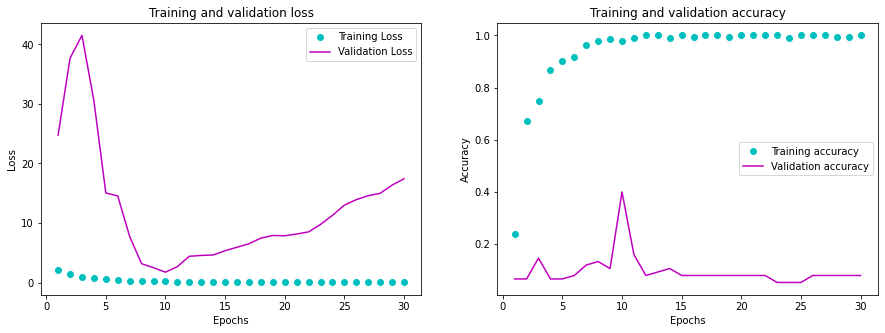

In [110]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [111]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 14.8633 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]], shape=(10, 10), dtype=int32)


In [112]:
model.save("model/Xception/fit-Adamax-Xception-0.0001.h5")

# intento 5

In [113]:
baseModel = Xception(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/Xception/base-Adamax-Xception-0.00001.h5")

In [114]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [115]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 208ms/step - loss: 2.3252 - accuracy: 0.0862 - val_loss: 20.0505 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 4s 178ms/step - loss: 2.2305 - accuracy: 0.1516 - val_loss: 35.3126 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 178ms/step - loss: 2.1962 - accuracy: 0.2148 - val_loss: 34.7460 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 179ms/step - loss: 2.0957 - accuracy: 0.3557 - val_loss: 23.8230 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 4s 179ms/step - loss: 2.0279 - accuracy: 0.4072 - val_loss: 13.5110 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 4s 179ms/step - loss: 1.9703 - accuracy: 0.4554 - val_loss: 22.6296 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 4s 178ms/step - loss: 1.8669 - accuracy: 0.5788 - val_loss: 7.3676 - val_accuracy: 0.0533


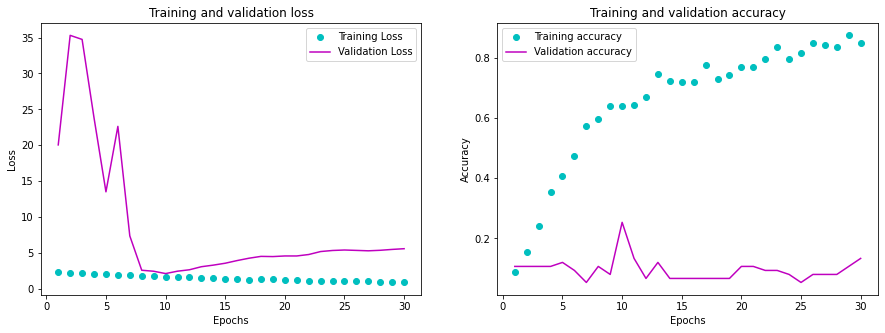

In [116]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [117]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 72ms/step - loss: 5.0734 - accuracy: 0.1400
Confusion_matrix:  tf.Tensor(
[[ 8  0  0  0  0  2  0  0  0  0]
 [ 8  0  0  0  0  2  0  0  0  0]
 [ 8  0  0  0  0  2  0  0  0  0]
 [ 6  0  0  0  0  4  0  0  0  0]
 [ 5  0  0  0  0  5  0  0  0  0]
 [ 4  0  0  0  0  6  0  0  0  0]
 [ 8  0  0  0  0  2  0  0  0  0]
 [ 3  0  0  0  0  7  0  0  0  0]
 [ 3  0  0  0  0  7  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [118]:
model.save("model/Xception/fit-Adamax-Xception-0.00001.h5")